# Tutorial on distribution approximation and posterior estimation

This notebook is an exercise in distribution approximation using Normalizing flows in the [pyro](https://pyro.ai/) implementation. Then it shows the use of distribution approximation in posterior estimation using ML4GW tools.

Libraries needed for the notebook are
- ml4gw
- pyro-ppl
- lightning
- scikit-learn


In [47]:
# uncomment to install these dependencies
# ! pip install scikit-learn
# ! pip install ml4gw 
# ! pip install lightning
# ! pip install pyro-ppl

In [48]:
from typing import Callable, List

import h5py
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from tqdm import tqdm

import torch
from torch import optim
from torch.distributions import Normal, TransformedDistribution

from pyro.nn import AutoRegressiveNN
from pyro.distributions.transforms import AffineAutoregressive

In [49]:
torch.manual_seed(1)
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [50]:
samples, labels = datasets.make_moons(n_samples=1000, noise=0.1)

Text(0, 0.5, '$y$')

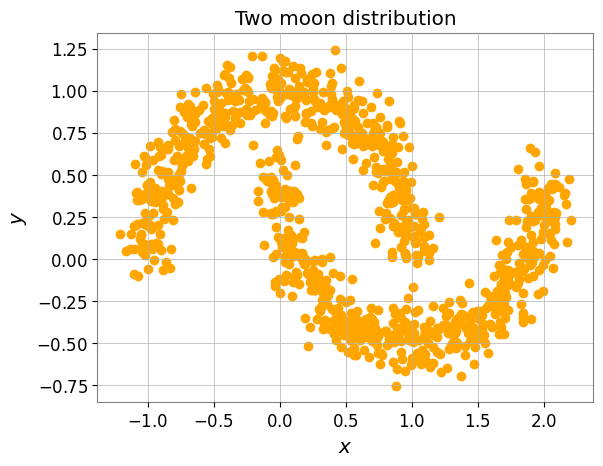

In [51]:
plt.scatter(samples.T[0], samples.T[1], color="orange")
plt.title("Two moon distribution")
plt.xlabel("$x$")
plt.ylabel("$y$")

In [52]:
samples = torch.from_numpy(samples).to(dtype=torch.float32, device=device)

## Normalizing flow using Autoregressive Transforms

The normalizing flow we implement below has affine autoregressive transforms. Most of the constructs are available in the pyro API.


In [53]:
input_dim = 2  # data dimension
hidden_dims = [50*input_dim, 50*input_dim, 50*input_dim]

base_dist = Normal(torch.zeros(input_dim, device=device), torch.ones(input_dim, device=device))

arn = AutoRegressiveNN(input_dim, hidden_dims, param_dims=[1, 1]).to(device)

In [54]:
# two dimensional input -> mu and sigma
with torch.no_grad():
    print(arn(torch.ones(1, 2, device=device)))


(tensor([[0.0149, 0.0908]], device='cuda:0'), tensor([[-0.0225, -0.0576]], device='cuda:0'))


In [55]:
transform =  AffineAutoregressive(arn).to(device)  # the "affine" part implies the linear relation between hidden dimensions

In [56]:
# the flow implementation is torch transformed distribution
flow_dist = TransformedDistribution(base_dist, [transform])

The `flow_dist` is the normalizing flow: It is a distribution which can be evaluated, and sampled from.

In [57]:
flow_dist.sample([10]) # -> 10 samples

tensor([[-0.3092,  2.6174],
        [-0.0878, -0.7060],
        [ 0.3213, -0.1771],
        [-1.4481,  2.3316],
        [ 0.0378, -2.5415],
        [-0.3469,  0.7560],
        [-1.3134, -0.0269],
        [-0.8357, -1.3689],
        [-0.4421,  0.1139],
        [-1.5013, -0.7086]], device='cuda:0')

In [58]:
# or evaluate the density
example_points = torch.tensor(
    [
        [0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.],
    ],
    device=device
)
with torch.no_grad():
    sample_log_prob = flow_dist.log_prob(example_points)
for sample, log_prob in zip(example_points, sample_log_prob):
    print(f"log p({sample}) = {log_prob:.3e}")

log p(tensor([0., 0.], device='cuda:0')) = -1.749e+00
log p(tensor([0., 1.], device='cuda:0')) = -2.220e+00
log p(tensor([1., 0.], device='cuda:0')) = -2.252e+00
log p(tensor([1., 1.], device='cuda:0')) = -2.728e+00


## Now we learn this distribution


In [59]:
optimizer = optim.Adam(transform.parameters(), lr=1e-4)


In [60]:
from IPython.display import clear_output
from time import sleep

def live_plot(x_vals, y_vals, iteration, labels=None):
    """Auxiliary function to visualize the distribution"""
    clear_output(wait=True)
    sleep(1)
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.scatter(x_vals, y_vals, label='proxy')
    ax.scatter(samples.cpu().T[0], samples.cpu().T[1], alpha=0.1, label='Orig.', c=labels)
    ax.legend()
    ax.set_title('iteration {}'.format(iteration))


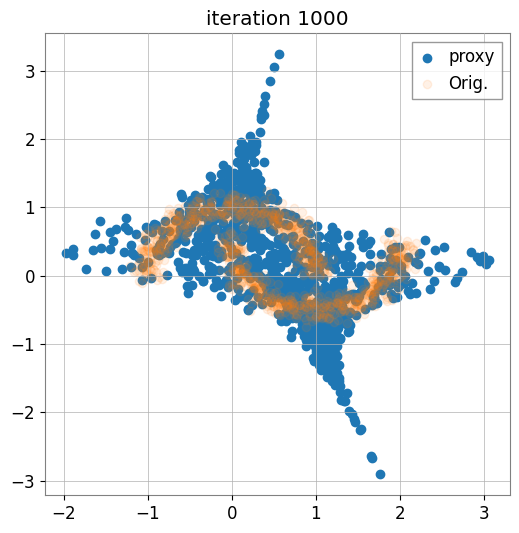

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 65.34it/s]


In [61]:
num_iter = 1000
for i in tqdm(range(num_iter)):
    optimizer.zero_grad()
    # take the original samples, and evaluate the likelihood.
    loss = -flow_dist.log_prob(samples).mean()
    loss.backward()
    optimizer.step()

    flow_dist.clear_cache()  # pyro modules cache values and derivatives for performance

    if (i + 1) % 100 == 0:
        with torch.no_grad():
            samples_flow = flow_dist.sample(torch.Size([1000,])).cpu().numpy()
        live_plot(samples_flow[:,0], samples_flow[:,1], i + 1)
        plt.show()



## Compose several transforms

In the previous case we just had a single transform. Now we compose several of those and repeat

In [62]:
transforms = [
    AffineAutoregressive(
        AutoRegressiveNN(
            input_dim, hidden_dims,
            param_dims=[1, 1]
        ).to(device)
    ) for _ in range(10)
]

flow_dist = TransformedDistribution(base_dist, transforms)

In [63]:
trainable_parameters = []

for t in transforms:
    trainable_parameters.extend(list(t.parameters()))


In [64]:
optimizer = optim.Adam(trainable_parameters, lr=1e-4)

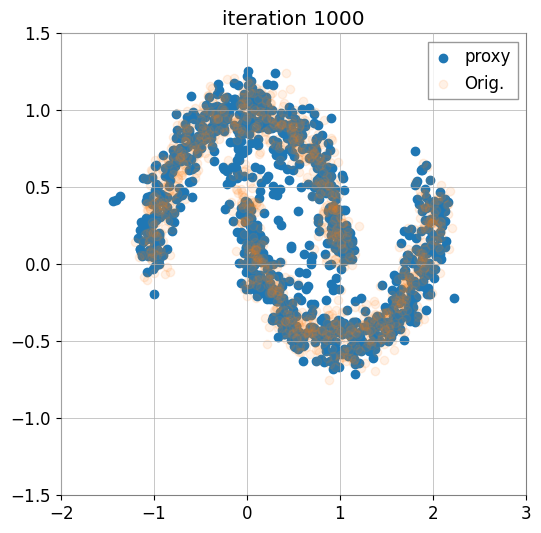

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.86it/s]


In [65]:
num_iter = 1000
for i in tqdm(range(num_iter)):

    optimizer.zero_grad()
    loss = -flow_dist.log_prob(samples).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if (i + 1) % 100 == 0:
        with torch.no_grad():
            samples_flow = flow_dist.sample(torch.Size([1000,])).cpu().numpy()

        live_plot(samples_flow[:,0], samples_flow[:,1], i + 1)
        plt.xlim((-2.0, 3.0))
        plt.ylim((-1.5, 1.5))
        plt.show()

## Condition and sample from each mode

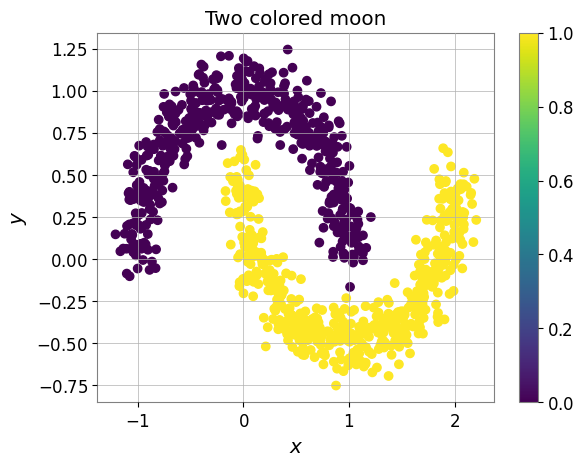

In [66]:
plt.scatter(samples.cpu().T[0], samples.cpu().T[1], c=labels)
plt.title("Two colored moon")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.colorbar()

In [67]:
labels = torch.from_numpy(labels).to(dtype=torch.float32, device=device).reshape(samples.shape[0], 1)

### Conditional distribution

Let's learn the conditional approximator based on the color

In [68]:
from pyro.distributions import ConditionalTransformedDistribution
from pyro.distributions.conditional import ConditionalComposeTransformModule
from pyro.nn.auto_reg_nn import ConditionalAutoRegressiveNN
from pyro.distributions.transforms import ConditionalAffineAutoregressive

In [69]:
condition_dim = 1 # the color is either 0 or 1
arn = ConditionalAutoRegressiveNN(input_dim, condition_dim, hidden_dims, param_dims=[1, 1]).to(device)

In [70]:
with torch.no_grad():
    print(
        arn(torch.ones(5, 2, device=device), context=torch.ones(5, 1, device=device))  # need to supply additional context
    )

(tensor([[-0.1096, -0.0174],
        [-0.1096, -0.0174],
        [-0.1096, -0.0174],
        [-0.1096, -0.0174],
        [-0.1096, -0.0174]], device='cuda:0'), tensor([[-0.0531,  0.0315],
        [-0.0531,  0.0315],
        [-0.0531,  0.0315],
        [-0.0531,  0.0315],
        [-0.0531,  0.0315]], device='cuda:0'))


In [71]:
transforms = [
    ConditionalAffineAutoregressive(
        ConditionalAutoRegressiveNN(
            input_dim, condition_dim, hidden_dims,
            param_dims=[1, 1]
        ).to(device)
    ).to(device) for _ in range(5)
]
conditional_flow_dist = ConditionalTransformedDistribution(base_dist, transforms)

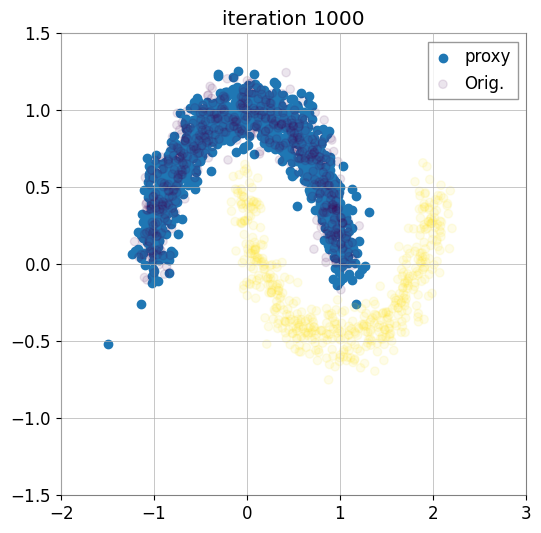

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 38.99it/s]


In [72]:
trainable_parameters = []
for t in transforms:
    trainable_parameters.extend(list(t.parameters()))

optimizer = optim.Adam(trainable_parameters, lr=1e-4)


num_iter = 1000
for i in tqdm(range(num_iter)):
    optimizer.zero_grad()
    loss = -conditional_flow_dist.condition(labels).log_prob(samples).mean()
    loss.backward()
    optimizer.step()
    conditional_flow_dist.clear_cache()

    if (i + 1) % 100 == 0:
        inference_label = ((i + 1) // 100) % 2  # alternate between modes
        with torch.no_grad():
            samples_one = conditional_flow_dist.condition(
                torch.tensor([inference_label,]).to(dtype=torch.float32, device=device)
            ).sample(torch.Size([1000,])).cpu().numpy()

        live_plot(samples_one[:,0], samples_one[:,1], i + 1, labels=labels.cpu())
        plt.xlim((-2.0, 3.0))
        plt.ylim((-1.5, 1.5))
        plt.show()

## Posterior estimation of gravitational-wave events

### Get background data from LIGO detectors

We will download some data from Sept 15, 2015, the day after the detection of GW150914


In [73]:
from gwpy.timeseries import TimeSeries, TimeSeriesDict
from pathlib import Path

# Point this to whatever directory you want to house
# all of the data products this notebook creates
data_dir = Path("/tmp/data")

# And this to the directory where you want to download the data
background_dir = data_dir / "background_data"
background_dir.mkdir(parents=True, exist_ok=True)

# This is a 10000s segment on Sept 15, 2015, the day after
# GW150914 was detected
segments = [
    (1126310417, 1126320417), 
]
ifos = ["H1", "L1"]  # Hanford and Livingston
sample_rate = 2048  # Hz

for (start, end) in segments:
    # Download the data from GWOSC. This will take a few minutes.
    duration = end - start
    fname = background_dir / f"background-{start}-{duration}.hdf5"
    if fname.exists():
        continue

    ts_dict = TimeSeriesDict()
    for ifo in ifos:
        ts_dict[ifo] = TimeSeries.fetch_open_data(ifo, start, end, cache=True)
    ts_dict = ts_dict.resample(sample_rate)
    ts_dict.write(fname, format="hdf5")

## Create simulations using ML4GW tools

In [74]:
from torch.distributions import Uniform

# ml4gw components
from ml4gw.waveforms import IMRPhenomD
from ml4gw.waveforms.generator import TimeDomainCBCWaveformGenerator
from ml4gw.waveforms.conversion import chirp_mass_and_mass_ratio_to_components

from ml4gw.gw import compute_observed_strain, get_ifo_geometry

from ml4gw.transforms import Whiten, SpectralDensity
from ml4gw.distributions import PowerLaw, Sine, Cosine


We will use `InMemoryDataset` for dataloading. This can send the entire background to the GPU memory before training commences, and generates waveforms on-the-fly.

This is useful for prototyping with small background stretches that is not too large to fit in device memory.

In [75]:

from ml4gw.dataloading import InMemoryDataset


In [76]:
# define priors to generate waveforms
prior_dict = {
    "chirp_mass": PowerLaw(10, 30, -2.35),
    "mass_ratio": Uniform(0.125, 0.999),
    "chi1": Uniform(-0.999, 0.999),
    "chi2": Uniform(-0.999, 0.999),
    "distance": PowerLaw(100, 700, 2.0),
    "phic": Uniform(0, 2*torch.pi),
    "inclination": Sine()
}

### We will infer only on a subset of parameters for this exercise

In [77]:

# define inference parameters for posterior estimation
inference_params = {k:prior_dict[k] for k in ['chirp_mass', 'distance']}

The `InMemoryDataset` is an `IterableDataset` that lazily loads batches from the background that is in device memory. We create a derived class that adds the capacity to do injections on top of lazily loaded batches. 

The main method below is `inject`. This yields a new background batch, dynamically estimates the PSD, generates and injects a batch of waveforms, and whitens it with the estimated PSD, all using `ml4gw` tools.

In [78]:
def split(X, frac, axis):
    size = int(frac * X.shape[axis])
    if isinstance(X, np.ndarray):
        return np.split(X, [size], axis=axis)
    else:
        splits = [size, X.shape[axis] - size]
        return torch.split(X, splits, dim=axis)


class InMemoryInjectionDataset(InMemoryDataset):
    def __init__(
        self,
        X,
        ifos: List[str] = ["H1", "L1"],
        kernel_length: int = 4.0,
        # PSD/whitening args
        fduration: float = 2,
        psd_length: float = 16,
        sample_rate: float = 2048,
        fftlength: float = 2,
        highpass: float = 32,
        # Dataloading args
        batch_size: int = 10,
        batches_per_epoch: int = 100,
        approximant = IMRPhenomD,
        prior_dict = prior_dict,
        f_min: float = 20,
        f_max: float = None,
        f_ref: float = 20,
        device: torch.device = device,
    ):
        self.kernel_size = int(kernel_length * sample_rate)
        self.sample_rate = sample_rate
        self.fduration = fduration
        self.window_size = self.kernel_size + int(fduration * sample_rate)
        self.psd_size = int(psd_length * sample_rate)
        self.batch_size = batch_size
        self.batches_per_epoch = batches_per_epoch
        self.device = device
        super().__init__(
            X,
            self.window_size + self.psd_size,
            None,
            self.batch_size,
            stride=1,
            batches_per_epoch=self.batches_per_epoch,
            coincident=False,
            shuffle=True,
            device=self.device,
        )
        self.ifos = ifos
        # real-time transformations defined with torch Modules
        self.spectral_density = SpectralDensity(
            sample_rate, fftlength, average="median", fast=False
        ).to(self.device)
        self.whitener = Whiten(
            fduration, sample_rate, highpass=highpass
        ).to(self.device)
        # define some sky parameter distributions
        self.prior_dict = prior_dict
        torch_pi = torch.as_tensor(torch.pi, device=self.device)
        self.dec = Cosine(-torch_pi / 2, torch_pi / 2)
        self.psi = torch.distributions.Uniform(0, torch_pi)
        self.phi = torch.distributions.Uniform(
            -torch_pi, torch_pi
        )  # relative RAs of detector and source
        self.approx = approximant().to(self.device)
        self.waveform_generator = TimeDomainCBCWaveformGenerator(
            approximant=self.approx,
            sample_rate=sample_rate,
            duration=kernel_length + fduration,
            f_min=f_min,
            f_ref=f_ref,
            right_pad=0.5,  # this means the merger is 0.5 seconds from the end
        ).to(self.device)
        self.detector_tensors, self.detector_vertices = get_ifo_geometry(*ifos)
        self.detector_tensors = self.detector_tensors.to(self.device)
        self.detector_vertices = self.detector_vertices.to(self.device)

    def project_waveforms(
        self, hc: torch.Tensor, hp: torch.Tensor
    ) -> torch.Tensor:
        # sample sky parameters
        N = len(hc)
        dec = self.dec.sample((N,)).to(hc)
        psi = self.psi.sample((N,)).to(hc)
        phi = self.phi.sample((N,)).to(hc)

        proj_params = {
            "dec": dec,
            "psi": psi,
            "phi": phi,
        }
        # project to interferometer response
        return compute_observed_strain(
            dec=dec,
            psi=psi,
            phi=phi,
            detector_tensors=self.detector_tensors,
            detector_vertices=self.detector_vertices,
            sample_rate=self.sample_rate,
            cross=hc,
            plus=hp,
        ), proj_params

    def generate_waveforms(self, batch_size: int) -> tuple[torch.Tensor, ...]:
        params = {
            k: v.sample((batch_size,)).to(self.device)
            for k, v in self.prior_dict.items()
        }
        # attach component masses if not present
        if "mass_1" not in params:
            params["mass_1"], params["mass_2"] = chirp_mass_and_mass_ratio_to_components(
                params["chirp_mass"], params["mass_ratio"]
            )
        if "s1z" not in params:
            params["s1z"], params["s2z"] = params["chi1"], params["chi2"]
        hc, hp = self.waveform_generator(**params)
        return hc, hp, params

    def inject(self, X: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # break off "background" from target kernel and compute its PSD
        # (in double precision since our scale is so small)
        background, X = torch.split(
            X, [self.psd_size, self.window_size], dim=-1
        )
        psd = self.spectral_density(background.double())

        # generate polarizations
        hc, hp, params = self.generate_waveforms(self.batch_size)

        # project 
        responses, proj_params = self.project_waveforms(hc, hp)
        
        # include sky params in returned params
        params.update(proj_params)

        # inject waveform into background and whiten
        X += responses.float()
        X = self.whitener(X, psd)

        return X, params

    def __iter__(self):
        for X in super().__iter__():
            X, params = self.inject(X)
            yield X, params

Now create a `Lightning` datamodule using the above dataset.

In [79]:
import pytorch_lightning as pl

In [80]:
class ML4GWInferenceDatamodule(pl.LightningDataModule):
    def __init__(
        self,
        background_file,
        ifos: List[str] = ["H1", "L1"],
        kernel_length: int = 4.0,
        # PSD/whitening args
        fduration: float = 2,
        psd_length: float = 16,
        sample_rate: float = 2048,
        fftlength: float = 2,
        highpass: float = 32,
        # Dataloading args
        batch_size: int = 10,
        batches_per_epoch: int = 100,
        approximant = IMRPhenomD,
        prior_dict = prior_dict,
        inference_params = inference_params,
        valid_frac: float = 0.2,
        f_min: float = 20,
        f_max: float = None,
        f_ref: float = 20,
    ):
        super().__init__()
        self.save_hyperparameters(
            ignore=[
                "background_file",
                "ifos",
                "approximant",
                "prior_dict",
                "inference_params"
            ]
        )
        self.background_file = background_file
        self.ifos = ifos
        self.approximant = approximant
        self.prior_dict = prior_dict
        self.inference_params = inference_params

    def setup(self, stage: str) -> None:
        if stage == 'fit' or stage == 'validate':
            # load background and fit whitener
            # load background data
            background = []
            with h5py.File(self.background_file) as f:
                for ifo in self.ifos:
                    hoft = f[ifo][:]
                    background.append(hoft)
            background = torch.from_numpy(np.stack(background))
            background, valid_background = split(
                background, 1 - self.hparams.valid_frac, 1)
            device = self.trainer.model.device if self.trainer else "cpu"
            common_kwargs = dict(
                ifos=self.ifos,
                kernel_length=self.hparams.kernel_length,
                fduration=self.hparams.fduration,
                psd_length=self.hparams.psd_length,
                sample_rate=self.hparams.sample_rate,
                fftlength=self.hparams.fftlength,
                highpass=self.hparams.highpass,
                batch_size=self.hparams.batch_size,
                batches_per_epoch=self.hparams.batches_per_epoch,
                approximant=self.approximant,
                prior_dict=self.prior_dict,
                f_min=self.hparams.f_min,
                f_max=self.hparams.f_max,
                f_ref=self.hparams.f_ref,
                device=device,
            )
            self.training_dataset = InMemoryInjectionDataset(
                background,
                **common_kwargs
            )
            self.validation_dataset = InMemoryInjectionDataset(
                valid_background,
                **common_kwargs
            )

    def train_dataloader(self):
        return self.training_dataset

    def val_dataloader(self):
        return self.validation_dataset


In [81]:
# example usage of the datamodule
datamodule = ML4GWInferenceDatamodule(background_dir / "background-1126310417-10000.hdf5")
datamodule.setup('validate')

In [82]:
for X_inj, param in datamodule.val_dataloader():
    break

In [83]:
print(X_inj.shape)
print(param['chirp_mass'])

torch.Size([10, 2, 8192])
tensor([16.6160, 16.1015, 10.7921, 14.9086, 14.4572, 14.3292, 16.2467, 25.9641,
        21.8948, 18.4409])


## Now we build the Normalizing flow as a `LightningModule`

The module has a learnable `architecture` which is used to summarize the strain data. The normalizing flow learns the distribution of the inference parameters given this data summary.

In [84]:

class ML4GWInferenceModel(pl.LightningModule):
    """A LFI model using ML4GW tools"""
    def __init__(
        self,
        architecture: torch.nn.Module,
        inference_params: List[str] = inference_params,
        num_transforms: int = 20,
        num_blocks: int = 5,
        hidden_features: int = 250,
        context_dim: int = 32,
        learning_rate: float = 0.001,
        activation: Callable = torch.nn.Tanh,
    ) -> None:
        super().__init__()
        self.save_hyperparameters(
            ignore=["architecture",]
        )
        self.nn = architecture
        # build the normalizing flow
        self.param_dim = len(inference_params)
        self.build_flow()

    def embedding_net(self, X):
        return self.nn(X)
    
    def training_step(self, batch, _):
        strain, param_dict = batch
        params = []
        for _ in self.hparams.inference_params.keys():
            params.append(param_dict[_])
        params = torch.stack(params, dim=1)
        loss = -self.log_prob(params, context=strain).mean()
        self.log(
            "train_loss", loss, on_step=True, prog_bar=True, sync_dist=False
        )
        return loss

    def validation_step(self, batch, _):
        strain, param_dict = batch
        params = []
        for _ in self.hparams.inference_params.keys():
            params.append(param_dict[_])
        params = torch.stack(params, dim=1)
        loss = -self.log_prob(params, context=strain).mean()
        self.log(
            "valid_loss", loss, on_epoch=True, prog_bar=True, sync_dist=True
        )
        return loss

    def configure_optimizers(self):
        parameters = self.nn.parameters()
        optimizer = torch.optim.AdamW(parameters, self.hparams.learning_rate)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            self.hparams.learning_rate,
            pct_start=0.1,
            total_steps=self.trainer.estimated_stepping_batches,
        )
        scheduler_config = dict(scheduler=scheduler, interval="step")
        return dict(optimizer=optimizer, lr_scheduler=scheduler_config)

    def configure_callbacks(self):
        chkpt = pl.callbacks.ModelCheckpoint(monitor="valid_loss", mode="min")
        return [chkpt]

    def transform_block(self):
        """Returns single autoregressive transform"""
        param_dim = len(self.hparams.inference_params)
        arn = ConditionalAutoRegressiveNN(
            param_dim,
            self.hparams.context_dim,
            self.hparams.num_blocks * [self.hparams.hidden_features],
            nonlinearity=self.hparams.activation(),
        )
        transform = ConditionalAffineAutoregressive(arn)
        return transform

    def flow(self):
        if not hasattr(self, "transforms"):
            raise RuntimeError("Flow is not built")
        return ConditionalTransformedDistribution(
            self.distribution(), self.transforms
        )

    def distribution(self):
        """Returns the base distribution for the flow"""
        return Normal(
            torch.zeros(self.param_dim, device=self.device),
            torch.ones(self.param_dim, device=self.device),
        )

    def build_flow(self):
        """Build the transform"""
        self.transforms = []
        for idx in range(self.hparams.num_transforms):
            _transform = self.transform_block()
            self.transforms.extend([_transform])
        self.transforms = ConditionalComposeTransformModule(self.transforms)

    def log_prob(self, x, context):
        """Wrapper `log_prob` from TransformedDistribution"""
        if not hasattr(self, "transforms"):
            raise RuntimeError("Flow is not built")
        embedded_context = self.embedding_net(context)
        flow = self.flow()
        return flow.condition(embedded_context).log_prob(x)

    def sample(self, n, context):
        """Wrapper around sample from TransformedDistribution object"""
        if not hasattr(self, "transforms"):
            raise RuntimeError("Flow is not built")
        n = [n] if isinstance(n, int) else n
        embedded_context = self.embedding_net(context)
        flow = self.flow()
        return flow.condition(embedded_context).sample(n)



In [85]:
from ml4gw.nn.resnet import ResNet1D
# we use a ResNet1D as the embedding network
architecture = ResNet1D(
    in_channels=2,
    layers=[5, 5],
    classes=32,
    kernel_size=5,
)

In [86]:
log_dir = "/tmp/pl-logs"

logger = pl.loggers.CSVLogger(log_dir, name="ml4gw-lfi-expt")

# create a fresh instance of the model
model = ML4GWInferenceModel(
    architecture=architecture,
)
datamodule = ML4GWInferenceDatamodule(
    background_dir / "background-1126310417-10000.hdf5",
    batch_size=500  # adjust based on your GPU memory
)


In [87]:

# invoke trainer
trainer = pl.Trainer(
    max_epochs=10,
    check_val_every_n_epoch=2,
    precision="16-mixed",
    log_every_n_steps=10,
    logger=logger,
    accelerator="auto",
)
trainer.fit(model, datamodule=datamodule)

Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name       | Type                              | Params | Mode 
-------------------------------------------------------------------------
0 | nn         | ResNet1D                          | 1.0 M  | train
1 | transforms | ConditionalComposeTransformModule | 5.2 M  | train
-------------------------------------------------------------------------
6.2 M     Trainable params
0   

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                   | 0/? [00:00<?, ?it/s]

Validation: |                                                   | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


There are a few key improvements in the production models deployed in LIGO-Virgo-KAGRA fourth observing run, compared to this tutorial (see the AMPLFI [methods](https://doi.org/10.1088/2632-2153/ad8982) and [validation](https://doi.org/10.48550/arXiv.2509.22561) papers):
- A multimodal embedding network involving both time and frequency-domain data views
- Standard scaling the parameters before forward-modeling with the normalizing flow
- Marginalizing over a time-of-arrival window using data augmentation and self-supervised learning